In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion

import sim_template as sim
from importlib import reload 

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#Setup the system:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
qBase = np.array([[1,10],[19,10]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 20
x_min = 0
y_max = 20
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 15
p_th = 0.7
n=1

In [4]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH)





Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [5]:
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs
#%store trismall_pcs
print(prob_pred_con)




Drawing 900 samples from Channel 1
Completed PredictedChannel 1
Drawing 900 samples from Channel 2
Completed PredictedChannel 2
[0.9399030694668821]


In [13]:
for pth in [0.5, 0.6, 0.7, 0.8, 0.9]:
    pred_joint_con_fields = [1*(pfs[i*2]*pfs[(i*2)+1]>pth) for i in range(len(ccs)//2)]

    pred_joint_con_pts = [ sim.field_to_pts(pred_joint_con_fields[i], ccs[i*2].region, res) for i in range(len(ccs)//2)]

    #calculate the probabilty of the point being in the predicted regions
    p_pred_connected = []
    for i in range(len(ccs)//2):
        #convert pred points back to grid points, but in res resolution
        idxs = sim.toGridFromRaw(ccs[(i*2)].region, res, pred_joint_con_pts[i])
        print(sim.prob_pred_in_true(true_joint_con_fields[i], idxs))
        
    raw_area = len(pred_joint_con_pts[0])*(1/res)**2
    print('Original area: %.2f'%(raw_area))
    if raw_area != 0:

        pt_cld = PC.PointCloud(pred_joint_con_pts[0])
        pt_cld.partition()
        reduced_area = 0
        n_cnvx = 0
        if pt_cld.polygons is not None:
            for poly in pt_cld.polygons:
                reduced_area += poly.area()
                n_cnvx += len(poly.cnvx_partition)
            print('Area after reduction: %.2f'%(reduced_area))
            print('Number of Convex Polygons in Partition: %d'%(n_cnvx))
            print('percent decrease: %.2f'%((raw_area - reduced_area)/raw_area))
    print('\n\n')

0.830316742081448
Original area: 21.61
Extracted edges...
Polygons constructed, looking for holes...
Constructed 6 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([14.06666667 15.46666667])  ([14.13333333 15.4       ])  ([14.13333333 15.46666667]) Is Interior: False
12 total subregions
Area after reduction: 20.44
Number of Convex Polygons in Partition: 12
percent decrease: 0.05



0.8966836734693877
Original area: 17.42
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([7.2        7.06666667])  ([7.26666667 7.13333333])  ([7.2 7.2]) Is Interior: False
9 total subregions
Area after reduction: 16.23
Number of Convex Polygons in Partition: 9
percent decrease: 0.07



0.9399030694668821
Original area: 13.76
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
Info: 

In [7]:
pt_cld = PC.PointCloud(pjcps[0])
pt_cld.partition()


Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([11. 11.])  ([11.06666667 11.        ])  ([11.06666667 11.06666667])  ([11.         11.06666667]) Is Interior: False
10 total subregions


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


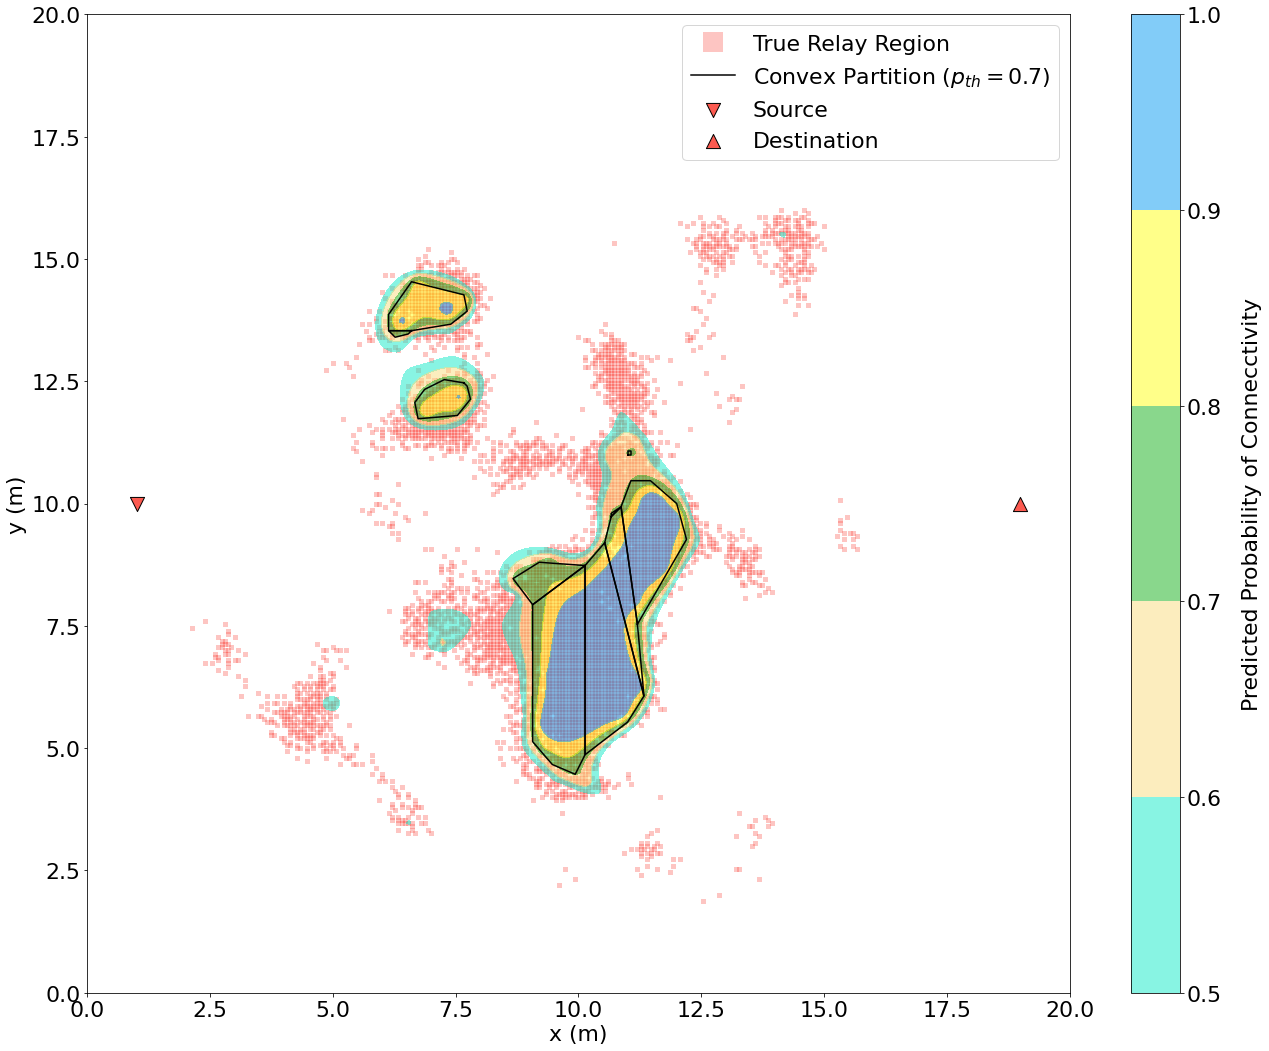

In [8]:
reload(sim)
sim.plotDecompFig(n, tjcps, pfs, qBase, region, pt_cld)
plt.gca().invert_yaxis()
# pt_cld.plot()

plt.savefig('sim_decomposition.png',format='png')
plt.show()

In [9]:
raw_area = len(pjcps[0])*(1/res)**2
print('Original area: %.2f'%(raw_area))

reduced_area = 0
n_cnvx = 0
for poly in pt_cld.polygons:
    reduced_area += poly.area()
    n_cnvx += len(poly.cnvx_partition)
print('Area after reduction: %.2f'%(reduced_area))
print('Number of Convex Polygons in Partition: %d'%(n_cnvx))

Original area: 13.76
Area after reduction: 12.82
Number of Convex Polygons in Partition: 10


0.06817447495961247